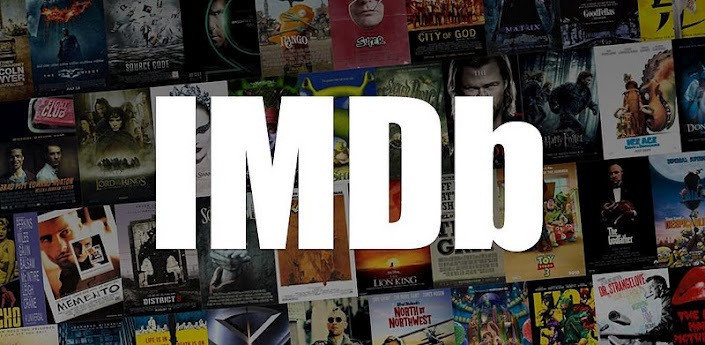

# Sentiment Analysis of IMDB Movie Reviews

The purpose of this project is analyzing the sentiment of IMDB movie reviews by implementing machine learning algorithms such asLogistic Regression, Naïve Bayes (NB) and Support Vector Machine (SVM).

In [48]:
import time
start_time = time.time()

## Importing Libraries

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from PIL import Image
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,\
                            accuracy_score,roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from bs4 import BeautifulSoup
import spacy
import en_core_web_sm
import string


import warnings
warnings.filterwarnings('ignore')

In [50]:
#Downloding nltk stop word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadarifurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammadarifurrahman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mohammadarifurrahman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [51]:
#set stopwords
# stopwords_list = set(stopwords.words("english"))
# more_stopwords = {'br', 'th', 'ti', 'di', 'dtype', 'one'}
# stopwords_list = stopwords_list.union(more_stopwords)
# stopwords_list.remove('not')

nlp = en_core_web_sm.load()
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stopwords_list = en.Defaults.stop_words

#sw_spacy.extend(['s', 've', 'd'])

more_sw = {'s', 've', 'd','br', 'th', 'ti', 'di', 'dtype'}
stopwords_list = stopwords_list.union(more_sw)
stopwords_list.remove('not')

## Dataset

To get news and information about a movie people around the world usually rely on the IMDb website. Since IMDb is the most popular and universally used website which has a huge collection of movie reviews data, in our proposed work we used IMDb Movie Review Dataset for sentiment analysis on movie reviews.

In [52]:
#importing the data
imdb_data=pd.read_csv('IMDB Dataset.csv')
imdb_data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [53]:
imdb_data.shape

(50000, 2)

In [54]:
imdb_data.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [55]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


This dataset contains 50000 movie reviews which includes positive and negative reviews. All these raw reviews were collected from IMDb website. Next we will visually analyze our data set.

## Exploratory Data Analysis

### 1. Number of Reviews in each Sentiment Class 

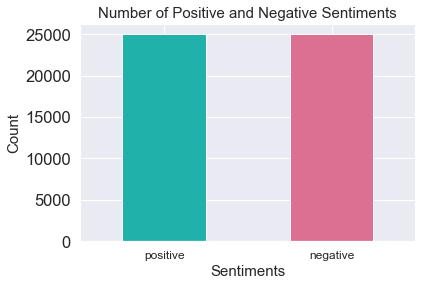

In [56]:
#sentiment count
sns.set_style('darkgrid')
sns.set(font_scale = 1.5)
imdb_data['sentiment'].value_counts().plot.bar(color=['lightseagreen', 'palevioletred'])
plt.xticks(rotation=0, fontsize=12)
plt.xlabel('Sentiments', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Number of Positive and Negative Sentiments', fontsize=15)
plt.show()

From the above plot we see, this data set is nicely balanced. We have 2500 reviews in each positive and negative side.

### 2. Number of words in reviews

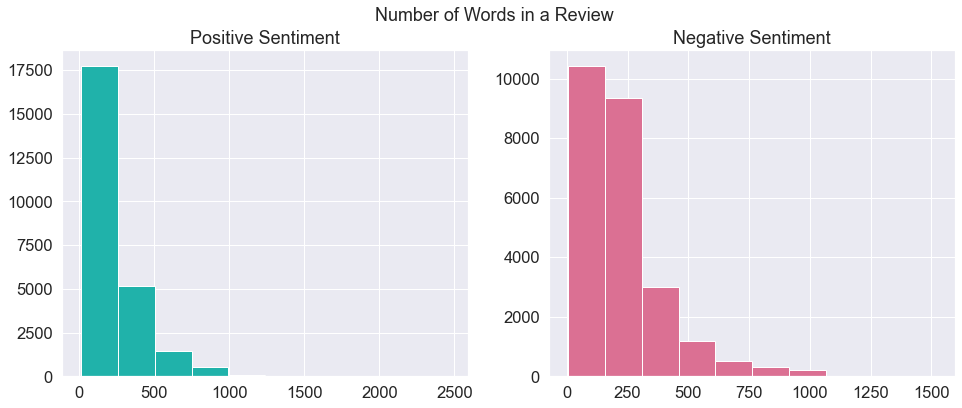

In [57]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
review_pos = imdb_data[imdb_data['sentiment']=='positive']['review'].str.split().map(lambda x: len(x))
ax[0].hist(review_pos,color = 'lightseagreen')
ax[0].set_title('Positive Sentiment')

review_neg = imdb_data[imdb_data['sentiment']=='negative']['review'].str.split().map(lambda x: len(x))
ax[1].hist(review_neg,color = 'palevioletred')
ax[1].set_title('Negative Sentiment')
plt.suptitle('Number of Words in a Review', fontsize = 18)
plt.show()

Histogram show that positive reviews contain fewer words compare to negative reviews. This actually make sense because when people are not satisfiesd with the movies or products they paid for, they tends to write longer reviews.

### 3. Positive Vs Negative Sentiment words

In [58]:
def word_cloud_process(text,  width, height, background_color='black', max_words=400, 
                       max_font_size=400, mask=None):

    wordcloud = WordCloud(stopwords = stopwords_list, 
                          max_words = max_words,
                          max_font_size=max_font_size,
                          mask=mask, background_color=background_color,
                          width=width, height=height)
    
    return wordcloud.generate(str(text))   

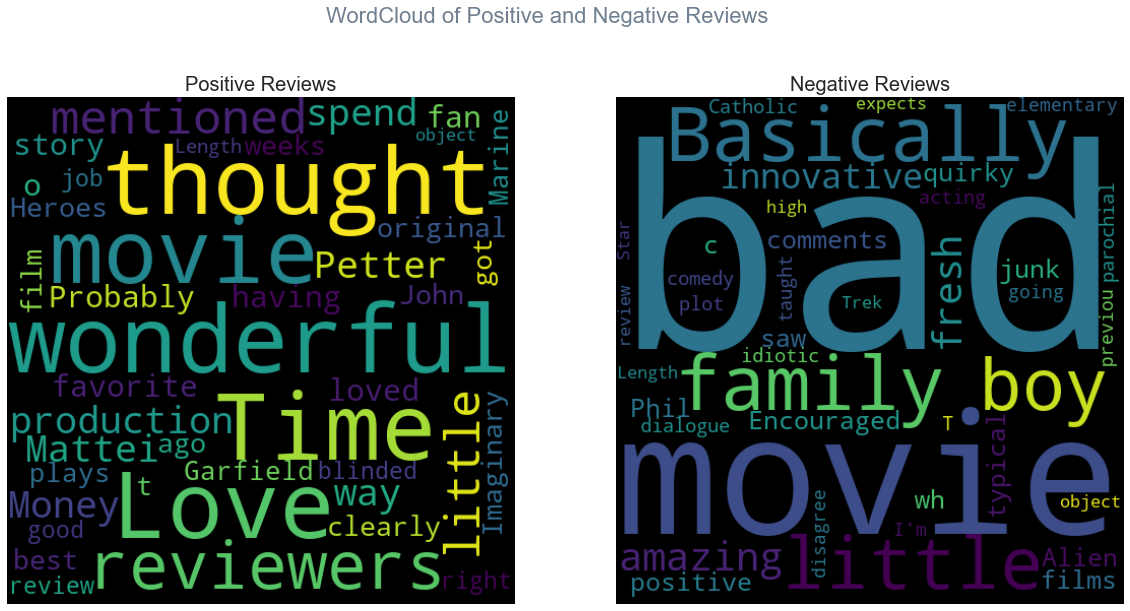

In [59]:
pos_rev = imdb_data[imdb_data['sentiment']=="positive"]['review']
neg_rev = imdb_data[imdb_data['sentiment']=="negative"]['review']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(word_cloud_process(pos_rev,width=500,height=500), interpolation='bilinear')
ax1.set_title('Positive Reviews', fontsize=20)
ax1.axis('off')

ax2.imshow(word_cloud_process(neg_rev,width=500,height=500), interpolation='bilinear')
ax2.set_title('Negative Reviews', fontsize=20)
ax2.axis('off')
plt.suptitle('WordCloud of Positive and Negative Reviews', fontsize=22, color='slategrey')

plt.show()

### From the word clouds above, we can say that
<br> 1) most frequent words used in positive reviews are Love, wonderful, Time, thought, loved etc. <br> 2) most frequent words used in negative reviews are bad, basically, junk, little, typical, family, etc.

### 4. Overall most common words

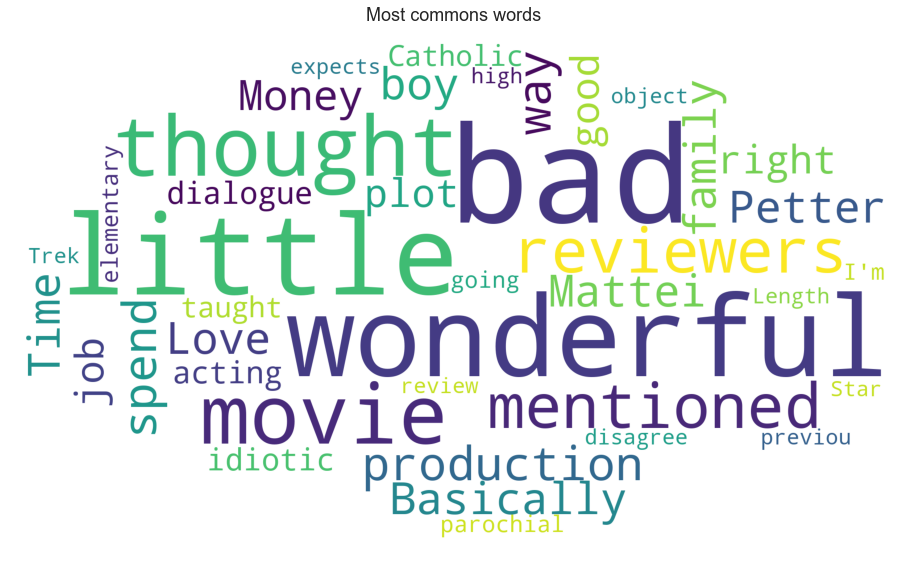

In [60]:
mask_all = np.array(Image.open('L3.png'))
plt.figure(figsize=(16,10))
plt.imshow(word_cloud_process(imdb_data['review'],1200,1000,background_color='white', 
                              max_font_size=300, mask=mask_all))
plt.axis('off')
plt.title('Most commons words', fontsize=18)
plt.show()

## Data Preparation

It is important to preprocess the data before execution of any classification algorithm. Basic preprocessing is applied to each reviews of the dataset which involves of lowercasing, stemming and removing noise characters and stop words. The following data preparation techniques are applied: 
* Data Cleaning
    * html tag removal
    * special character removal
    * lowercasing
* Stop Words removal
    * Tokenization
* Lemmatization

In [61]:
def data_clean(text):
    #remove html tags
    text_new = BeautifulSoup(text, "html.parser").get_text()
    #lower casing
    text_new = text_new.lower()
    #removing special characters
    text_new = re.sub(r'[^a-zA-z\s]',' ', text_new)
    #removing stop words
    words = [word for word in text_new.split() if word not in stopwords_list]
    text_new = " ".join(words)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    text_new = ' '.join([lemmatizer.lemmatize(word) for word in text_new.split()])
    
   
    return text_new 

In [62]:
def data_clean2(text):
    #lower casing
    text_new = text.lower()
    #remove html tags
    text_new = text_new.replace('<br />', ' ')
    #removing punctions
    text_new = text_new.translate(str.maketrans('', '', string.punctuation))
    #removing stop words
    words = [word for word in text_new.split() if word not in stopwords_list]
    text_new = " ".join(words)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    text_new = ' '.join([lemmatizer.lemmatize(word) for word in text_new.split()])
    
   
    return text_new 

In [63]:
print('Sample review before data preprocessing')
print(imdb_data['review'][2])
print('\n')
print('Sample review after data preprocessing')
print(data_clean2(imdb_data['review'][2]))

Sample review before data preprocessing
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.


Sample review after data prepro

In [64]:
# #Apply data cleaning function on review column
# s = time.time()
# imdb_data['review']=imdb_data['review'].apply(data_clean)
# e=time.time()
# imdb_data['review'].head()

In [65]:
# print(f'time:{e-s}')

In [66]:
#Apply data cleaning function on review column
s2 = time.time()
imdb_data['review']=imdb_data['review'].apply(data_clean2)
e2 = time.time()
imdb_data['review'].head()

0    reviewer mentioned watching 1 oz episode youll...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: review, dtype: object

In [195]:
# print(f'time:{e2-s2}')

In [196]:
# #just to avoid re run
# #saving cleaned file to pickel
# imdb_data['review'].to_pickle('cleaned_data.pickle')

In [197]:
# cleaned_df = pd.read_pickle('/Users/mohammadarifurrahman/Projects/Movie Review 2/untitled folder/cleaned_data.pickle')
# imdb_data['review'] = cleaned_df
#cleaned_df.head()

## Feature Extraction

The feature extraction or vectorization process is an important step for analyzing text which convert text into a matrix (or vector) of features. Since, the machine learning algorithms cannot work on the raw text directly, we need to use some feature extraction techniques that can transform the text data into numeric representations so that the data can be comprehensible by machine learning algorithms. In this project, we use 2 different feature extraction techniques:Bag of Words and TF-IDF with the combination of uni-gram and bi-gram.



In [67]:
def ngram_all(corpus, feature, nrange, n=None):
    if feature == 'bow':
        cv = CountVectorizer(ngram_range=nrange)
    elif feature == 'tfidf':
        cv = TfidfVectorizer(ngram_range=nrange)
    bag_of_words = cv.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    df = pd.DataFrame(total_list,columns=['text','count'])
    return df

In [68]:
uni_cv = ngram_all(imdb_data['review'], 'bow', (1,1), 10)
bi_cv = ngram_all(imdb_data['review'], 'bow', (2,2), 10)

uni_tfidf = ngram_all(imdb_data['review'], 'tfidf', (1,1), 10)
bi_tfidf = ngram_all(imdb_data['review'], 'tfidf', (2,2), 10)

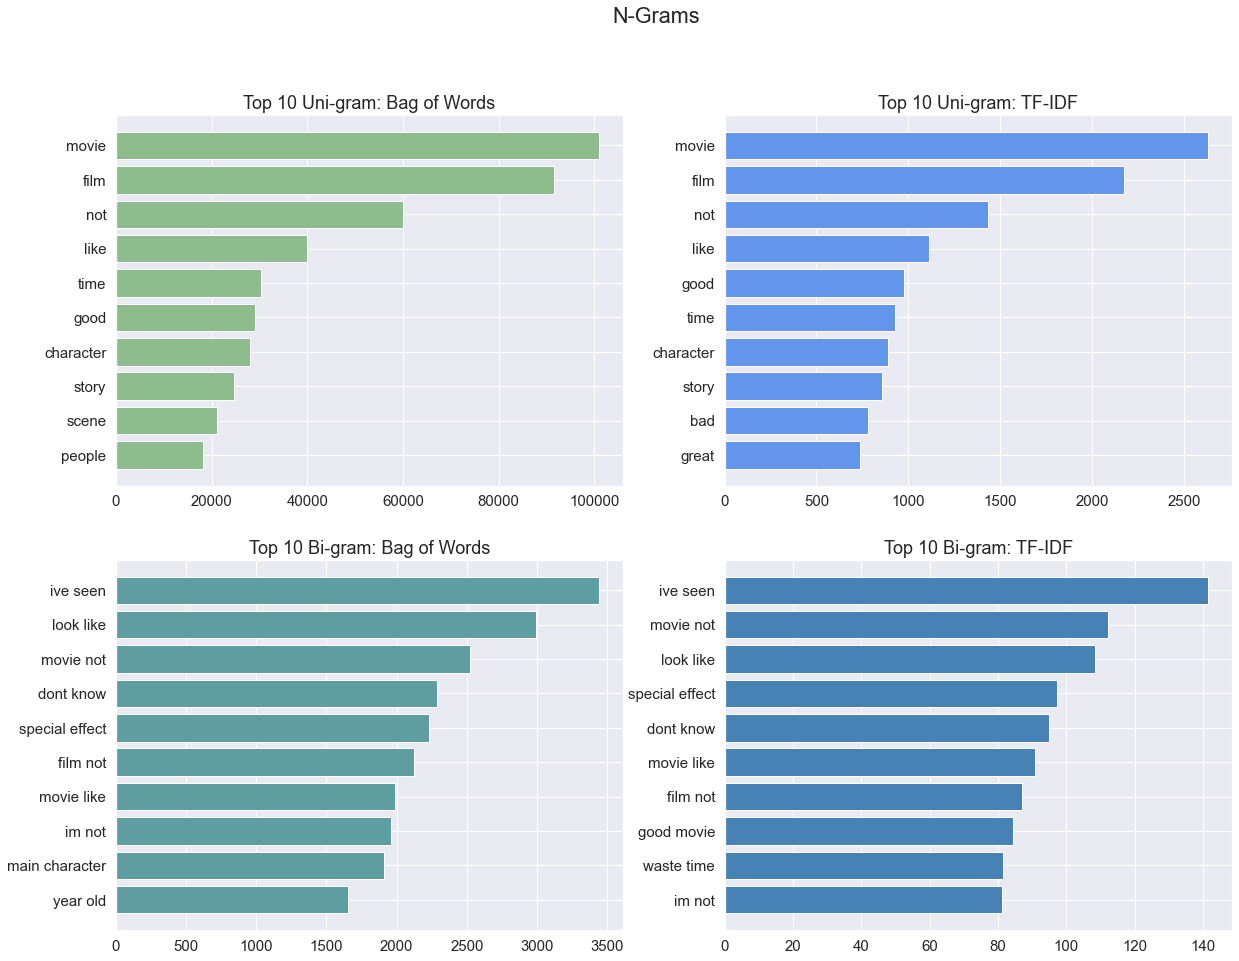

In [70]:
fig, ax = plt.subplots(2,2, figsize = (20,15))

ax[0,0].barh(y=uni_cv['text'][::-1], width=uni_cv['count'][::-1],color = 'darkseagreen')
ax[0,0].tick_params(labelsize=15)
ax[0,0].set_title('Top 10 Uni-gram: Bag of Words')

ax[0,1].barh(y=uni_tfidf['text'][::-1], width=uni_tfidf['count'][::-1],color = 'cornflowerblue')
ax[0,1].tick_params(labelsize=15)
ax[0,1].set_title('Top 10 Uni-gram: TF-IDF')

ax[1,0].barh(y=bi_cv['text'][::-1], width=bi_cv['count'][::-1],color = 'cadetblue')
ax[1,0].tick_params(labelsize=15)
ax[1,0].set_title('Top 10 Bi-gram: Bag of Words')

ax[1,1].barh(y=bi_tfidf['text'][::-1], width=bi_tfidf['count'][::-1],color = 'steelblue')
ax[1,1].tick_params(labelsize=15)
ax[1,1].set_title('Top 10 Bi-gram: TF-IDF')

plt.suptitle('N-Grams')

plt.show()

## Modeling

Before moving into our NLP models first we will split the data set into 
* train (80 percent)
* test  (20 percent)

also we will change snetiments labels to 0 and 1.

In [71]:
# Split dataset into input and output

X = imdb_data['review']
y = imdb_data['sentiment']

In [72]:
y.unique()

array(['positive', 'negative'], dtype=object)

In [73]:
y

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [74]:
#labeled the sentiments
y = y.replace({'negative':0, 'positive':1})
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [75]:
X=X.values
y=y.values

Here we have changed the sentiments labels to 0 and 1 from 'negative' and 'positive'.

In [76]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


In this project we spilt the 50000 movie reviews into to categories: train data and test data. First to train our model we selected 80 percent of data or 40000 reviews as train data. Then the rest 20 percent of the data or 10000 reviews are considered as test data to predict the sentiment in our proposed model.

## Classification Models

The main purpose of this project is the classification of reviews which is the process of assigning labels to the reviews whose label is unknown. Consequently, for this classification task we implemented Naïve Bayes classifier and SVM model to analyze the sentiment of the IMDB movie reviews.

In [77]:
def model_report_with_featureEX(model, feature_ex_method, ngram, X=X, X_train=X_train, 
                                X_test=X_test, y_train=y_train, y_test=y_test):
    
    #Feature Extraction
    if feature_ex_method == 'TFIDF':
        fv = TfidfVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is TF-IDF')
    elif feature_ex_method == 'BOW':
        fv = CountVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is BoW')
    else:
        fv = CountVectorizer(ngram_range=ngram).fit(X)
        print('Feature Extraction Method is BoW')
    
#     X_train_data = fv.transform(X_train).toarray()
#     X_test_data = fv.transform(X_test).toarray()
    
    X_train_data = fv.transform(X_train)
    X_test_data = fv.transform(X_test)
    
    
    #Modeling

    model_fit = model.fit(X_train_data, y_train)
    acc_score = model_fit.score(X_test_data, y_test)

    #ROC curve
    y_pred_proba = model_fit.predict_proba(X_test_data)[::,1]

    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
        
    predict = model_fit.predict(X_test_data)

    print(f'Ngram range: {ngram}')
    print(f'Accuracy: {acc_score*100:.2f}%')
    print('')

    report = classification_report(y_test, predict, target_names=['Negative', 'Positive'])
    print(report)
    
    return fpr, tpr, auc, X_train_data, X_test_data

### Logistic Regression

In [38]:
#Logistic regression Model
lr = LogisticRegression()

In [39]:
print('---- Logistic Regression:BoW with UniGram -------')
lr1 = model_report_with_featureEX(lr,'BOW', (1,1))

---- Logistic Regression:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 88.03%

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      4981
    Positive       0.88      0.89      0.88      5019

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [40]:
print('---- Logistic Regression:BoW with UniBiGram -------')
lr2 = model_report_with_featureEX(lr,'BOW', (1,2))

---- Logistic Regression:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 89.34%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4981
    Positive       0.89      0.90      0.89      5019

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [41]:
print('---- Logistic Regression:TFIDF with UniGram -------')
lr3 = model_report_with_featureEX(lr,'TFIDF', (1,1))

---- Logistic Regression:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 88.79%

              precision    recall  f1-score   support

    Negative       0.90      0.87      0.89      4981
    Positive       0.88      0.91      0.89      5019

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [42]:
print('---- Logistic Regression:TFIDF with UniBiGram -------')
lr4 = model_report_with_featureEX(lr,'TFIDF', (1,2))

---- Logistic Regression:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 88.46%

              precision    recall  f1-score   support

    Negative       0.91      0.86      0.88      4981
    Positive       0.87      0.91      0.89      5019

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



### Naïve Bayes Classifier

In [43]:
#Naive Bayes Model
mnb=MultinomialNB()

In [44]:
print('---- Naive Bayes:BoW with UniGram -------')
nb1 = model_report_with_featureEX(mnb,'BOW', (1,1))

---- Naive Bayes:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 85.90%

              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      4981
    Positive       0.87      0.84      0.86      5019

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [45]:
print('---- Naive Bayes:BoW with UniBiGram -------')
nb2 = model_report_with_featureEX(mnb,'BOW', (1,2))

---- Naive Bayes:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 87.80%

              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88      4981
    Positive       0.89      0.87      0.88      5019

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [46]:
print('---- Naive Bayes:TFIDF with UniGram -------')
nb3 = model_report_with_featureEX(mnb,'TFIDF', (1,1))

---- Naive Bayes:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 86.63%

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      4981
    Positive       0.87      0.86      0.87      5019

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [47]:
print('---- Naive Bayes:TFIDF with UniBiGram -------')
nb4 = model_report_with_featureEX(mnb,'TFIDF', (1,2))

---- Naive Bayes:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 88.30%

              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88      4981
    Positive       0.89      0.88      0.88      5019

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### SVM Classifier

In [48]:
#instantiate the model
svc = LinearSVC(dual=False) 
SVM = CalibratedClassifierCV(svc) 


In [49]:
print('---- SVM:BoW with UniGram -------')
svm1 = model_report_with_featureEX(SVM,'BOW', (1,1))

---- SVM:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 86.94%

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      4981
    Positive       0.86      0.88      0.87      5019

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [50]:
print('---- SVM:BoW with UniBiGram -------')
svm2 = model_report_with_featureEX(SVM,'BOW', (1,2))

---- SVM:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 89.08%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4981
    Positive       0.88      0.90      0.89      5019

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [51]:
print('---- SVM:TFIDF with UniGram -------')
svm3 = model_report_with_featureEX(SVM,'TFIDF', (1,1))

---- SVM:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 89.16%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4981
    Positive       0.89      0.90      0.89      5019

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [52]:
print('---- SVM:TFIDF with UniBiGram -------')
svm4 = model_report_with_featureEX(SVM,'TFIDF', (1,2))

---- SVM:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 89.96%

              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      4981
    Positive       0.89      0.91      0.90      5019

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [53]:
# svm4[4].toarray()

### Random Forest

In [54]:
rf = RandomForestClassifier()

In [55]:
print('---- random forest:BoW with UniGram -------')
rf1 = model_report_with_featureEX(rf,'BOW', (1,1))

---- random forest:BoW with UniGram -------
Feature Extraction Method is BoW
Ngram range: (1, 1)
Accuracy: 85.64%

              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85      4981
    Positive       0.85      0.86      0.86      5019

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [56]:
print('---- random forest:BoW with UniBiGram -------')
rf2 = model_report_with_featureEX(rf,'BOW', (1,2))

---- random forest:BoW with UniBiGram -------
Feature Extraction Method is BoW
Ngram range: (1, 2)
Accuracy: 85.90%

              precision    recall  f1-score   support

    Negative       0.88      0.83      0.85      4981
    Positive       0.84      0.89      0.86      5019

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [57]:
print('---- random forest:TFIDF with UniGram -------')
rf3 = model_report_with_featureEX(rf,'TFIDF', (1,1))

---- random forest:TFIDF with UniGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 1)
Accuracy: 85.73%

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      4981
    Positive       0.86      0.86      0.86      5019

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [58]:
print('---- random forest:TFIDF with UniBiGram -------')
rf4 = model_report_with_featureEX(rf,'TFIDF', (1,2))

---- random forest:TFIDF with UniBiGram -------
Feature Extraction Method is TF-IDF
Ngram range: (1, 2)
Accuracy: 86.02%

              precision    recall  f1-score   support

    Negative       0.88      0.84      0.86      4981
    Positive       0.85      0.88      0.86      5019

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



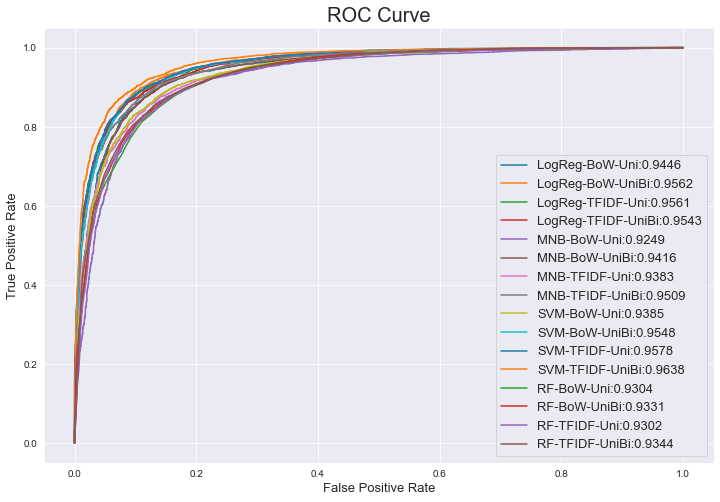

In [60]:
plt_list = [lr1, lr2, lr3, lr4, nb1, nb2, nb3, nb4, 
            svm1, svm2, svm3, svm4, rf1, rf2, rf3, rf4]
model_name = ['LogReg-BoW-Uni', 'LogReg-BoW-UniBi', 'LogReg-TFIDF-Uni', 'LogReg-TFIDF-UniBi',
             'MNB-BoW-Uni', 'MNB-BoW-UniBi', 'MNB-TFIDF-Uni', 'MNB-TFIDF-UniBi',
              'SVM-BoW-Uni', 'SVM-BoW-UniBi', 'SVM-TFIDF-Uni', 'SVM-TFIDF-UniBi',
             'RF-BoW-Uni', 'RF-BoW-UniBi', 'RF-TFIDF-Uni', 'RF-TFIDF-UniBi']

plt.figure(figsize=(12,8))
for models, label in zip(plt_list, model_name):
    
    plt.plot(models[0], models[1], label=f'{label}:'+str(f'{models[2]:.4f}'))
    plt.legend(loc=4, fontsize=13)
    
plt.ylabel('True Positive Rate', fontsize=13)
plt.xlabel('False Positive Rate', fontsize=13)
plt.title('ROC Curve', fontsize=20)
plt.show()

### Lime

In [78]:
# for LIME import necessary packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
from sklearn.pipeline import make_pipeline


In [79]:
# Explaining the predictions and important features for predicting the label 1
tfidf = TfidfVectorizer(ngram_range=(1,2)).fit(X)
pipe = make_pipeline(tfidf, SVM)

In [80]:
class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names=class_names)

In [102]:
idx = 124
exp = explainer.explain_instance(X_test[idx], pipe.predict_proba, 
                                 num_features=20,labels=(1,))

In [131]:
def re_label(predict):
    if predict == 0:
        return 'negative'
    else: return 'positive'

In [137]:
print(f'Predicted: {re_label(pipe.predict([X_test[idx]]))}\n')
print(f'Actual: {re_label(y_test[idx])}')
exp.show_in_notebook(text=X_test[idx])

Predicted: negative

Actual: negative


In [138]:
idx = 1
exp = explainer.explain_instance(X_test[idx], pipe.predict_proba, 
                                 num_features=20,labels=(1,))
print(f'Predicted: {re_label(pipe.predict([X_test[idx]]))}\n')
print(f'Actual: {re_label(y_test[idx])}')
exp.show_in_notebook(text=X_test[idx])

Predicted: positive

Actual: positive


**Now let's explore a review that the model has labeled wrong.**

In [140]:
idx = 312
exp = explainer.explain_instance(X_test[idx], pipe.predict_proba, 
                                 num_features=20,labels=(1,))
print(f'Predicted: {re_label(pipe.predict([X_test[idx]]))}\n')
print(f'Actual: {re_label(y_test[idx])}')
exp.show_in_notebook(text=X_test[idx])

Predicted: negative

Actual: positive


In [150]:
list_wrong_prediction_index = [i for (i,(j,k)) in enumerate(zip(pipe.predict(X_test), y_test)) if j!=k]
#list_wrong_prediction_index

In [151]:
list_wrong_prediction_index

[2,
 6,
 19,
 23,
 24,
 42,
 49,
 62,
 80,
 85,
 102,
 107,
 120,
 122,
 136,
 152,
 169,
 171,
 173,
 193,
 201,
 206,
 207,
 208,
 220,
 221,
 225,
 236,
 248,
 251,
 261,
 276,
 289,
 300,
 303,
 312,
 313,
 317,
 320,
 358,
 370,
 372,
 378,
 386,
 388,
 397,
 400,
 402,
 407,
 432,
 454,
 455,
 471,
 473,
 476,
 494,
 503,
 508,
 513,
 526,
 528,
 534,
 545,
 555,
 561,
 581,
 601,
 608,
 610,
 628,
 634,
 635,
 651,
 652,
 655,
 671,
 674,
 688,
 710,
 712,
 717,
 718,
 731,
 742,
 759,
 772,
 773,
 782,
 805,
 823,
 826,
 831,
 832,
 842,
 850,
 853,
 862,
 887,
 895,
 900,
 911,
 925,
 939,
 950,
 957,
 969,
 974,
 983,
 992,
 993,
 1004,
 1014,
 1038,
 1042,
 1044,
 1046,
 1069,
 1073,
 1084,
 1088,
 1118,
 1123,
 1125,
 1138,
 1141,
 1147,
 1166,
 1184,
 1198,
 1203,
 1217,
 1254,
 1255,
 1256,
 1263,
 1267,
 1269,
 1276,
 1280,
 1281,
 1305,
 1310,
 1327,
 1345,
 1346,
 1350,
 1363,
 1367,
 1378,
 1409,
 1418,
 1433,
 1437,
 1444,
 1446,
 1467,
 1486,
 1503,
 1527,
 1535,
 1

## Conclusion

In conclusion, by comparing the performance results of Logistic Regression, Naïve Bayes, and SVM for unigram and combination of unigram and bigram, it is clear that the SVM classifier with TF-IDF unigram bigram mixture technique (accracy 90%, AUC: 0.96) outperformed all the other approaches.

### Deep Learning Approach

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import text, sequence 
from keras.utils import pad_sequences
from keras.layers import TextVectorization, Dense, \
                LSTM, Dropout, Embedding, Bidirectional

In [4]:
#importing data again
df_lstm = pd.read_csv('IMDB Dataset.csv')
# Split dataset into input and output

X_lstm = df_lstm['review'].values
y_lstm = df_lstm['sentiment']
#labeled the sentiments
y_lstm = y_lstm.replace({'negative':0, 'positive':1})
y_lstm = y_lstm.values

In [5]:
# split the data set into train and test
X_train_lstm_text, X_test_lstm_text, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=13)

In [6]:
def data_clean3(text):
    #lower casing
    lower_text = tf.strings.lower(text)
    #remove html tags
    html_removed_text = tf.strings.regex_replace(lower_text, '<br />', ' ')
    #removing punctions
    text_new = tf.strings.regex_replace(html_removed_text, 
                        f'[{re.escape(string.punctuation)}]', '')   
    return text_new

In [7]:
# Model constants
#Number of words
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [8]:
vectorize_layer = TextVectorization(
    standardize=data_clean3,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

Metal device set to: Apple M1


2022-08-01 19:39:17.365733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 19:39:17.365930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
vectorize_layer.adapt(X_train_lstm_text)
vectorize_layer.adapt(X_test_lstm_text)

2022-08-01 19:39:19.376477: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 19:39:19.495927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:21.712917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
# padded_sequences = pad_sequences(
#     vect_text, 
#     maxlen=sequence_length, 
#     padding='post'
# )

In [11]:
X_train_lstm = vectorize_layer(X_train_lstm_text)
X_test_lstm = vectorize_layer(X_test_lstm_text)

In [21]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)

(40000, 500)
(10000, 500)


In [12]:
X_train_lstm

<tf.Tensor: shape=(40000, 500), dtype=int64, numpy=
array([[1125,    5,    4, ...,    0,    0,    0],
       [  21,  114,    4, ...,    0,    0,    0],
       [  10,  266,   11, ...,    0,    0,    0],
       ...,
       [6428,   13,   73, ...,    0,    0,    0],
       [4157,    6,   46, ...,    0,    0,    0],
       [   2,   17,  508, ...,    0,    0,    0]])>

In [13]:
lstm = Sequential()
lstm.add(Embedding(input_dim=max_features, output_dim=embedding_dim))
#lstm.add(LSTM(units=64, return_sequences=True))
lstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
#lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(32)))
lstm.add(Dropout(0.2))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dropout(0.1))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [14]:

lstm_fit = lstm.fit(X_train_lstm, y_train_lstm, batch_size=64, epochs=5, verbose=1,
                    validation_data = (X_test_lstm,y_test_lstm),
                    validation_split = 0.2)


Epoch 1/5


2022-08-01 19:39:37.554026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:37.881221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:37.894285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:39.330319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:39.342643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:40.805911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:39:40.821751: I tensorflow/core/grappler/optimizers/cust

625/625 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.7812

2022-08-01 19:44:37.131293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:44:37.267782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:44:37.276870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:44:38.694965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 19:44:38.703263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 345s 531ms/step - loss: 0.4772 - accuracy: 0.7812 - val_loss: 0.3598 - val_accuracy: 0.8589
Epoch 2/5
625/625 [==============================] - 326s 521ms/step - loss: 0.3289 - accuracy: 0.8681 - val_loss: 0.3232 - val_accuracy: 0.8680
Epoch 3/5
625/625 [==============================] - 325s 520ms/step - loss: 0.2380 - accuracy: 0.9126 - val_loss: 0.3177 - val_accuracy: 0.8790
Epoch 4/5
625/625 [==============================] - 328s 525ms/step - loss: 0.1733 - accuracy: 0.9397 - val_loss: 0.3169 - val_accuracy: 0.8869
Epoch 5/5
625/625 [==============================] - 328s 525ms/step - loss: 0.1504 - accuracy: 0.9491 - val_loss: 0.3315 - val_accuracy: 0.8731


In [15]:
# Evaluate model on test data and print accuracy
scores = lstm.evaluate(X_test_lstm, y_test_lstm,
                       batch_size=64, verbose=0)
print("Accuracy: %.4f %%" % (scores[1]*100))

Accuracy: 87.3100 %


In [16]:
y_pred_lstm = lstm.predict(X_test_lstm)


2022-08-01 20:07:48.888896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 20:07:49.029426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 20:07:49.037847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 20:07:50.514544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 20:07:50.522581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 81s 250ms/step


In [17]:
y_pred_lstm_norm = [1 if i>0.5 else 0 for i in y_pred_lstm]
#y_pred_lstm_norm

In [18]:
y_test_lstm

array([0, 0, 1, ..., 1, 0, 1])

              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      5058
    Positive       0.87      0.88      0.87      4942

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



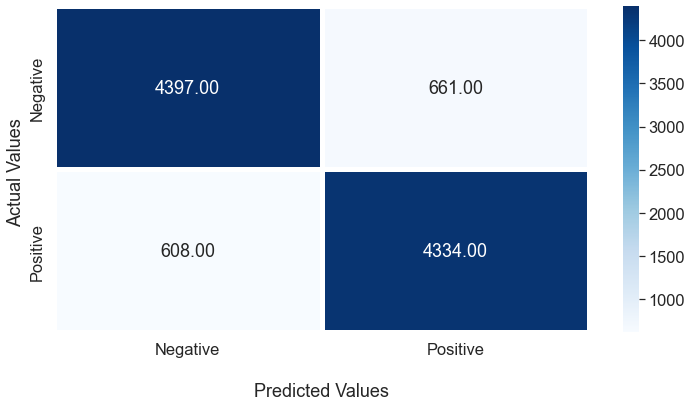

In [47]:
sns.set(font_scale = 1.5)
levels = ['Negative', 'Positive']
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm_norm)
print(classification_report(y_test_lstm, y_pred_lstm_norm,target_names=levels))
plt.figure(figsize=(12,6))
#seaborn confusion matrix
ax = sns.heatmap(cm_lstm, annot=True, linewidths=5, fmt='.2f', cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticks labels
ax.xaxis.set_ticklabels(levels)
ax.yaxis.set_ticklabels(levels)
#matplotlib confusion matix
# cmd = ConfusionMatrixDisplay(cm_lstm, display_labels=levels)
# cmd.plot()
plt.show()

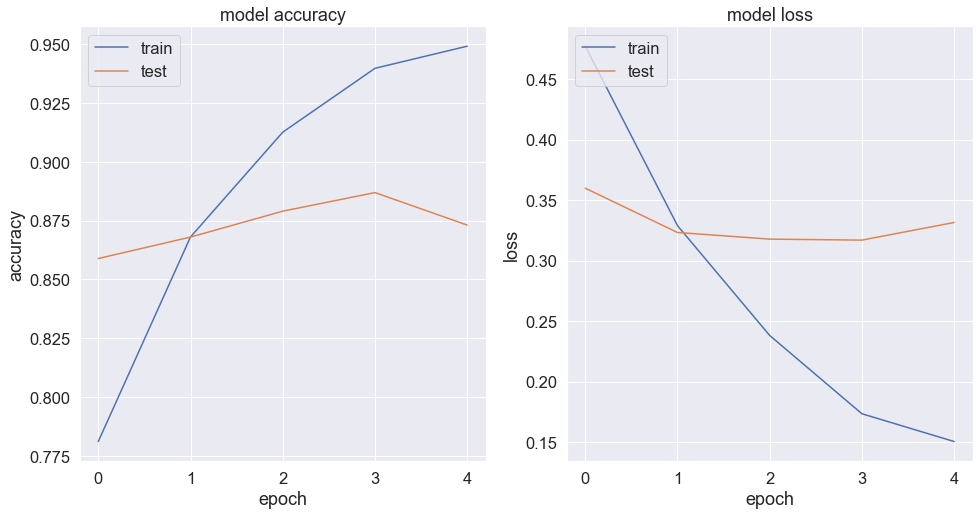

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].plot(lstm_fit.history['accuracy'])
axes[0].plot(lstm_fit.history['val_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[1].plot(lstm_fit.history['loss'])
axes[1].plot(lstm_fit.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(lstm, X_train_lstm[0:200])
# shap_values = explainer.shap_values(X_test_lstm[:10])

In [35]:
lstm.predict(X_test_lstm[2:3])

1/1 [==============================] - 0s 266ms/step


array([[0.9824968]], dtype=float32)